In [5]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import numpy.random as npr
import jax

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

In [6]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards):
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:, :-1, :]  - Xt[:, 1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, 1:,:] - b_minus[:, :-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

    @staticmethod
#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        def inner_loss_loop(x):
            t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
            main_term = cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            return main_term + cross_entropy 
            
#         for x in batch:
#             t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            
#             cross_entropy = log_kde_pdf_per_point(Xt[terminal_index].reshape(-1,1), batch_terminal_empirical, H)
            
#             J += cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            
#             J += cross_entropy
        
#         J /= len(batch)
        J = np.mean(inner_loss_loop(batch))
        J = np.squeeze(J)
#         J = J.block_until_ready() 
        return J
    
    @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)
        dt = self.dt
        N = self.number_time_steps
        sde_solver = self.sde_solver
        sigma = self.sigma

        def inner_loss_loop(x):
            t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            return Xt[-1, :]

        batch_y = jax.vmap(inner_loss_loop)(batch_x)
        return batch_y
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        for i in range(IPFP_iterations):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
#                     print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
#                     print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
         

        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

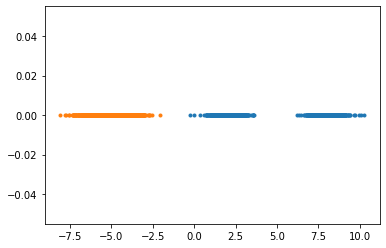

In [7]:
n = 1000
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 8
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 2
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [31]:
c = cIPFP(X2, X1,  number_time_steps=100, batch_size=100 , step_size = 0.0001, weights=[500,250])

In [32]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [33]:
theta_f[0][1].shape, theta_f[1]

((500,), ())

In [34]:
t, Xt = c.sample_trajectory(X1[0].reshape(-1,1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

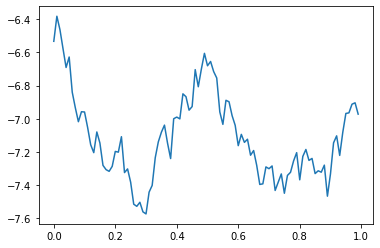

In [35]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [289]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [14]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [15]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [16]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 752 ms, sys: 10.3 ms, total: 762 ms
Wall time: 810 ms


DeviceArray(61.630344, dtype=float32)

In [17]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 16.8 ms, sys: 55 µs, total: 16.8 ms
Wall time: 10.5 ms


DeviceArray(68.25656, dtype=float32)

In [294]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [295]:
from jax import grad


In [18]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.81 s, sys: 25.1 ms, total: 2.84 s
Wall time: 3.39 s


In [19]:
%%time
kek = gradient(theta_f, X1, True)

CPU times: user 6.91 ms, sys: 588 µs, total: 7.5 ms
Wall time: 2.79 ms


loss b 38.42931365966797
loss f 1092.733642578125


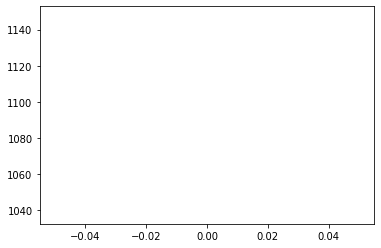

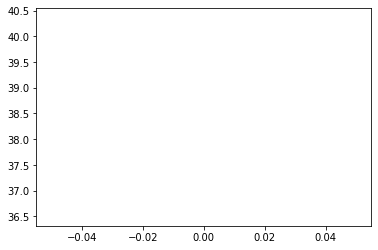

CPU times: user 1min 4s, sys: 611 ms, total: 1min 4s
Wall time: 1min 12s


In [36]:
%%time
c.fit(1,1)

loss b 47.553462982177734
loss f 1184.078369140625


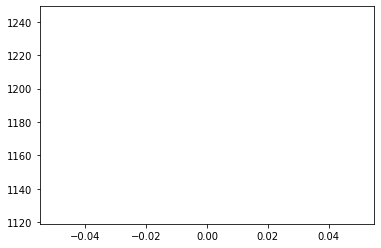

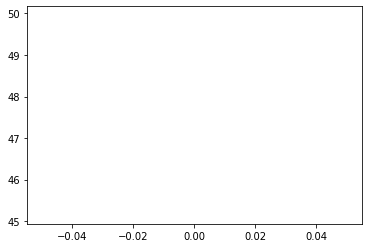

CPU times: user 2.87 s, sys: 1 s, total: 3.87 s
Wall time: 4.33 s


In [38]:
%%time
c.fit(1,1)

loss b 53.81342315673828
loss b 50.54841995239258
loss b 35.70028305053711
loss b 47.95658874511719
loss b 42.49689865112305
loss b 37.19879150390625
loss b 37.763832092285156
loss b 36.924705505371094
loss b 32.77532958984375
loss b 34.85627746582031
loss b 34.20017623901367
loss b 29.51727867126465
loss b 32.11006546020508
loss b 29.95719337463379
loss b 21.336658477783203
loss b 29.307415008544922
loss b 25.715761184692383
loss b 22.34992218017578
loss b 25.711875915527344
loss b 23.064319610595703
loss b 23.45252227783203
loss b 23.37952423095703
loss b 23.93263816833496
loss b 19.51534652709961
loss b 22.6512508392334
loss b 19.65187644958496
loss b 20.047290802001953
loss b 12.9348783493042
loss b 18.80071258544922
loss b 18.66222381591797
loss f 963.8701782226562
loss f 1105.0467529296875
loss f 1120.4869384765625
loss f 1051.262939453125
loss f 1014.7026977539062
loss f 815.6256713867188
loss f 875.4462280273438
loss f 717.9158935546875
loss f 772.8427734375
loss f 854.72460937

loss b 3.1184682846069336
loss b 2.6815335750579834
loss b 2.7766690254211426
loss b 3.123236894607544
loss f 24.34733772277832
loss f 66.21135711669922
loss f 50.18266296386719
loss f 65.67664337158203
loss f 51.50709533691406
loss f 28.4149227142334
loss f 53.08921813964844
loss f 61.95066833496094
loss f 73.0203628540039
loss f 49.77043533325195
loss f 46.37266159057617
loss f 35.47003936767578
loss f 55.61111068725586
loss f 52.60723876953125
loss f 42.42313003540039
loss f 60.31561279296875
loss f 43.987491607666016
loss f 43.917030334472656
loss f 42.12092971801758
loss f 58.74008560180664
loss f 33.84208297729492
loss f 35.49715805053711
loss f 63.24408721923828
loss f 26.95499610900879
loss f 37.08987808227539
loss f 33.37784957885742
loss f 18.66986656188965
loss f 20.246524810791016
loss f 33.051727294921875
loss f 25.604816436767578
loss b 2.948965072631836
loss b 2.88045072555542
loss b 2.602065324783325
loss b 2.500391960144043
loss b 3.234330654144287
loss b 2.77557754516

loss f 6.957972049713135
loss f 10.423133850097656
loss f 16.039649963378906
loss f 18.474742889404297
loss f 8.754317283630371
loss f 8.114364624023438
loss f 9.512284278869629
loss f 11.447021484375
loss f 14.26732349395752
loss f 8.181985855102539
loss f 12.640620231628418
loss f 11.508952140808105
loss f 16.160802841186523
loss b 1.6060032844543457
loss b 1.1763545274734497
loss b 1.4925659894943237
loss b 1.4027827978134155
loss b 1.4588109254837036
loss b 1.4311535358428955
loss b 1.3450989723205566
loss b 1.4157954454421997
loss b 1.313476324081421
loss b 0.8810808658599854
loss b 1.4716349840164185
loss b 1.313961386680603
loss b 1.2632595300674438
loss b 0.7786968350410461
loss b 1.0381970405578613
loss b 0.6055445075035095
loss b 0.7289160490036011
loss b 1.2303048372268677
loss b 1.18720281124115
loss b 0.6819281578063965
loss b 0.8771852254867554
loss b 0.7937566637992859
loss b 1.3725005388259888
loss b 1.0986523628234863
loss b 1.072489619255066
loss b 0.8285613059997559


loss b 1.7625306844711304
loss b 0.5673414468765259
loss b 0.6295452117919922
loss b 0.37350720167160034
loss b -0.07495325058698654
loss b -0.11071981489658356
loss b 0.5587723851203918
loss b 0.25762856006622314
loss b 0.5614727735519409
loss b 0.4327613413333893
loss b 0.7214415073394775
loss b -0.2327798306941986
loss b 0.8207943439483643
loss b 0.38652700185775757
loss b 1.5228126049041748
loss b 0.3876070976257324
loss b 5.654138088226318
loss b 2.202213764190674
loss b 0.3306838274002075
loss b 0.0068180495873093605
loss b 1.0894900560379028
loss b 1.4656500816345215
loss f 5.680530548095703
loss f 7.126184463500977
loss f 4.912555694580078
loss f 4.459954738616943
loss f 4.905168533325195
loss f 5.762349605560303
loss f 6.326803207397461
loss f 5.517836093902588
loss f 6.327756404876709
loss f 6.5714945793151855
loss f 7.094548225402832
loss f 4.561431407928467
loss f 4.894245147705078
loss f 4.420806407928467
loss f 6.004975318908691
loss f 4.511381149291992
loss f 6.335941791

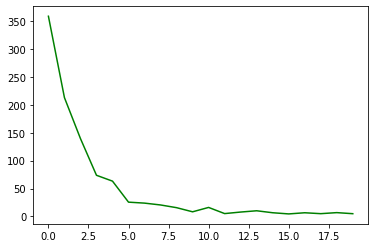

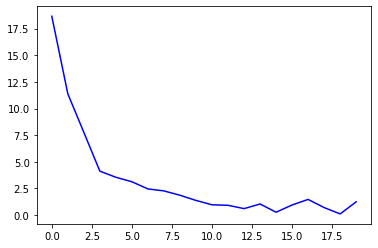

In [39]:
c.fit(20,30)

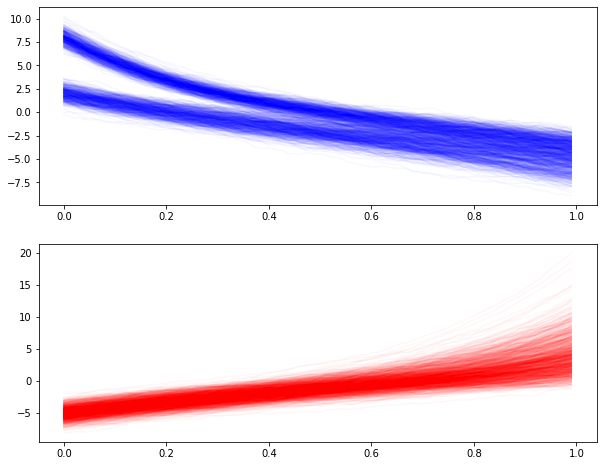

In [61]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
for x1 in X2:
    t, Xt = c.sample_trajectory(x1.reshape(1,-1),c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, forwards=True)
    axs[0].plot(t.flatten(), Xt.flatten(), 'b', alpha=0.03, )
BXt = []   

for x2 in X1:
    t_, Xt_ = c.sample_trajectory(x2.reshape(1,-1),c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver, forwards=False)
    BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten()[0:100], Xt_.flatten(), 'r', alpha=0.03)


In [25]:
import jax.numpy as np
import numpy as onp
import jax
import pylab as pl
from jax import jit
from functools import partial

key = jax.random.PRNGKey(0)
# key = None
onp.random.seed(0)


@partial(jit, static_argnums=(0,1, 4))
def inner_jit(alfa, beta, Y, ti, N, Dn, DWs, Wn, dt, theta):
    N = int(N)
    alfa_ = alfa
    if theta is not None:
        alfa_ = lambda X,t: alfa(theta, X)
        
    def inner_loop(n, Y):
        t = ti[n]
        a, b, DWn = alfa_(Y[:,n, :], t), beta(Y[:,n, :], t), DWs[:,n,:]
        # print Y[n,:]
        newY = (  
            Y[:,n, :] + a * Dn + b * DWn * Wn + 
            0.5 * ( beta(Y[:,n, :] + b * np.sqrt(Dn), t) - b ) * 
            (DWn**2.0 - Dn) / np.sqrt(Dn)
        )
        
        Y = jax.ops.index_update(Y, jax.ops.index[:,n+1,:],  newY)
        return Y
    
    Y = jax.lax.fori_loop (0, N-1, inner_loop, Y)

    return ti, Y


# @jit
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                key = key, theta=None):
    """
            Kloeden - Numerical Solution of stochastic differential
            equations (Springer 1992)  page XXX.
            Strong order 1.0 Runge Kutta scheme.
            http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_%28SDE%29
            dX = a(X,t)*dt + b(X, t)*dW
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
    randn = onp.random.randn
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")
    n, d = X0.shape
        
    X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
    DWs  = randn(n, N-1, d)  * np.sqrt(dt)
    
    
    Y, ti = np.zeros((n, N, d)), np.arange(N)*dt + t0
    Y = jax.ops.index_update(Y, jax.ops.index[:,0,:],  X0)
    
    Dn, Wn = dt, 1
        
    return inner_jit(alfa, beta, Y, ti, N, Dn, DWs, Wn, dt, theta)

In [62]:
# @partial(jit, static_argnums=(0,2))
npr.seed(0)
def transport_batch(self, batch_x, forwards):
    theta = self.theta_f if forwards else self.theta_b    
    b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

    def inner_loss_loop_23(x_):
#         print(x_, "_")
#         t, Xt = self.sample_trajectory(x_, self.dt, theta,  self.sigma, b, self.number_time_steps, self.sde_solver, forwards)
        t, Xt = solve_sde_RK(alfa=b, beta=self.sigma, dt=self.dt, X0=x_.reshape(-1,1), N=100, theta=theta)
#         print(Xt[-1,:], x_.shape)
        return Xt[:,-1,:]

#     batch_y = list(map(inner_loss_loop_23, batch_x))
#     print(batch_x.shape)
#     batch_y = jax.vmap(inner_loss_loop_23, in_axes=(0, ))(batch_x) # .block_until_ready()
#     for x in batch_y:
#         plt.plot(t_.flatten(), x.flatten(), 'r', alpha=0.3)
#     tmp = [x for x in bat]
    return inner_loss_loop_23(batch_x)

In [63]:
# X22 = transport_batch(c, X1, True)

In [70]:
X11 = np.array(transport_batch(c, X2, True)).flatten()

In [71]:
X22 = np.array(transport_batch(c, X1, False)).flatten()

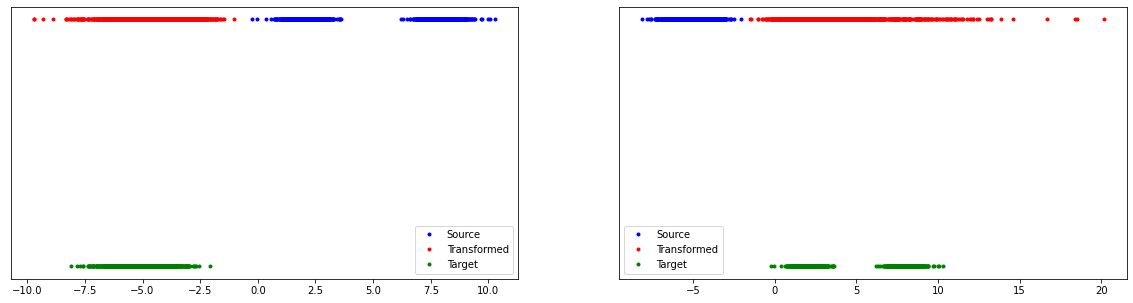

In [72]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

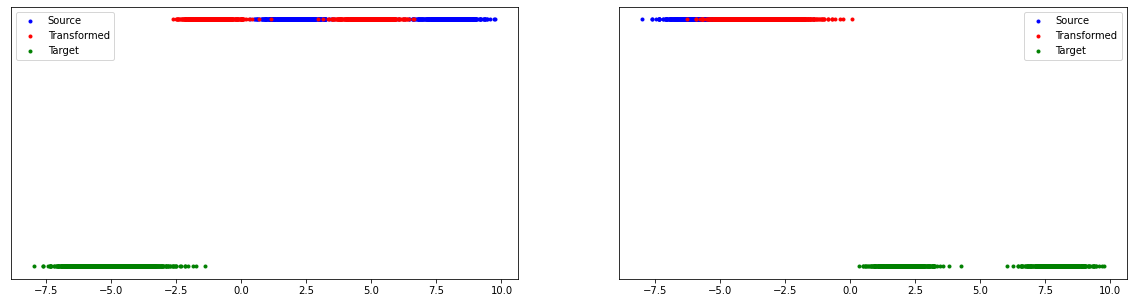

In [848]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [604]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

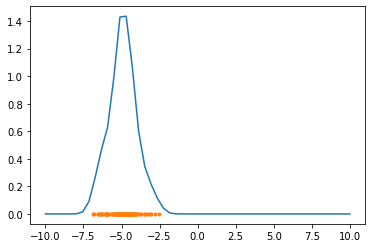

In [418]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [419]:
batch_terminal_empirical_b = next(c.data_stream(False))

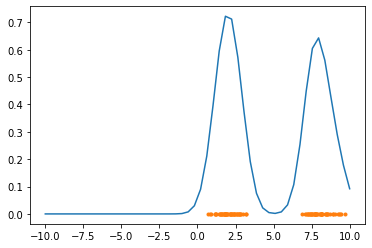

In [420]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")